This is just exact diagonalization from scratch instead of using qutip. **The difference with qpc_qutip_fermionic is that here we are not including the fermionic, redundant degrees of freedom as in that case.  We are just building the basis for spinless fermion in the computational basis.Meaning our hilbert space is of dimension $2L_{qpc}$**

These functions are the same I have on the scattering region analysis notebook

In [1]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
"""from scipy.fft import fft, ifft, fftfreq
from scipy.integrate import simpson
from scipy.interpolate import UnivariateSpline"""

import qutip
sys.path.append('../../scripts') 
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/perturbative/"
data_route = "../../data/sims/L=21/"


# Functions

In [90]:
def create_hamiltonians(L, T, Bond):
    # creates the decoupled and interacting hamiltonians 
    
    # L_qpc = qpc lattice sites
    # T = qubit hopping
    # BOnd = index for bond locatin
    H_matrix = np.zeros((2*L,2*L))
    # fill in the dd hopping 
    d_indices= kth_diag_indices(H_matrix,1)
    H_matrix[d_indices] = -T
    
    # fill in the QPC hopping
    d_indices= kth_diag_indices(H_matrix,2)
    H_matrix[d_indices] = -J[0]
    
    # when qpc and qubit hop a the same time there is no contribution
    d_indices= kth_diag_indices(H_matrix,1)
    odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
    H_matrix[odd_inds] = 0
    
    # save the free hamiltonian for later use
    Hdeco = H_matrix.copy()
    
    # Fill in the interaction at the bond
    H_matrix[2*Bond,2*(Bond+1)] = H_matrix[2*Bond,2*(Bond+1)]+ Omega
    
    # Now the elemets below the diagonal
    for i in range(0,2*L):
        for j in range(i + 1, 2*L):
            H_matrix[j, i] = H_matrix[i, j]
            Hdeco[j, i] = Hdeco[i, j]
            
    return H_matrix, Hdeco

    
def get_DD_init_for_fixed_k(k_prime):
    # calculated the initial conditions of the DD such that, when the QPC hits the bond
    # its state is the same as that of a DD initialized localized in the first site when 
    # the QPC for that case hits the bond with an average momentum k0=pi/2
    # k_prime: float. The momentum of the qpc particle
     
    alpha0 = np.cos( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
    beta0 = - 1j*np.sin( (t*bond_index)/(2*J[0])*(1/np.sin(k_prime) - 1) )
                        
    return alpha0, beta0

def get_bands(Eigen_energies, Eigen_vectors, Minus_indices, Plus_indies):
    # separates eigenvectors and eigenvalues into plus/minus enegy bands
    # and then sorts by enegy magnitude
    
    # minus band
    Energies_m = Eigen_energies[Minus_indices]
    States_m = Eigen_vectors[:,Minus_indices]
    # sort by magnitude
    Energies_m, States_m = mag_sort(Energies_m, States_m)
    
    # plus band
    Energies_p = Eigen_energies[Plus_indies]
    States_p = Eigen_vectors[:,Plus_indies]
    # sort by magnitude
    Energies_p, States_p = mag_sort(Energies_p, States_p)
    
    return Energies_m, States_m, Energies_p, States_p

def time_evolve(Psi0, Tau, states_m, Energies_m, states_p, Energies_p):
    # time evolve a state up psi0 to time Tau with eigenstates states_m for anti-band
    # and states_p for symmetric band
    psi_t = []

    # lattice basis
    for i in range(0, 2*L_qpc):
        aa = np.zeros(2*L_qpc)+ 0*1j
        # energy basis
        for k in range(0,len(k_single_band)):
            aa += np.exp(-1j*Tau*Energies_m[k])*np.conj(states_m[:,k])*states_m[i,k]+ \
                    np.exp(-1j*Tau*Energies_p[k])*np.conj(states_p[:,k])*states_p[i,k]

        psi_t.append(np.dot(Psi0,aa))

    return np.asarray(psi_t)

In [91]:

def schmidt_qubit_qpc(c_eigs):
    # calculates the schmidt decomposition between the QPC and qubit for some stae
    # given how we build our hamiltonian, the 0qubit-eigenstates are in the even indices
    # while the 1qubit ones are in the odd indices
    # c_eigs is the state vector

    # arange in MPS form for SVD
    col_1 = np.asarray(c_eigs[0::2]).reshape(-1,1)
    col_2 =  np.asarray(c_eigs[1::2]).reshape(-1,1)
    psi_mat = np.concatenate((col_1, col_2), axis=1)
    U, S, Vh = np.linalg.svd(psi_mat)

    return U, S, Vh

def get_QPC_occupations(Psi):
    # apply the density opperator to the full composite Psi and return the
    # densities a teach of the QPC sites
    occ_list = []

    for j in range(0,L_qpc):
        basis_j = np.zeros(L_qpc)
        basis_j[j] = 1
        # create density operator for the jth qoc lattice
        ketbra = np.outer(basis_j, np.conj(basis_j))
        # tensor with the qubit identity
        Nj_op = np.kron(ketbra, np.eye(2))
        occ_list.append(np.vdot(Psi, Nj_op @ Psi).real)
    return np.asarray(occ_list)

def get_qubit_occupations(Psi):
    # apply the density opperator to the full composite Psi and return the
    # densities a teach of the QPC sites
    occ_list = []

    # create density operator for the 0th qubit state 
    ketbra = np.outer([1,0], np.conj([1,0]))
    # tensor with the qubit identity
    Nj_op = np.kron(np.eye(L_qpc), ketbra)
    return np.vdot(Psi, Nj_op @ Psi).real

def get_transmision_proba(Om, k0,dot_density, Delta, k_arr ,J, Bond):
    # in the limit where we have very localized state the transmision probability is approximately that of the
    # one for K0
    V0 =  Om*J*dot_density
    T0 = 1 / (1 + (V0 / k_arr) ** 2)

    # effective mass
    m = 2*J*np.cos(k0)

    # the momentum distribution
    k_arr = np.linspace(-200, 200, 5000)
    Psi0k_abs = np.exp(-(Delta** 2)*(k_arr - k0) ** 2)
    # now with the wave packet weights
    T_k = 1 / (1 + (V0*m/ k_arr) ** 2)
    T_tot = simpson(T_k * Psi0k_abs, dx=k_arr[1] - k_arr[0])

    return T0, T_tot


# Main

In [98]:
L_qpc = 21
L = L_qpc + 2
Omega = 0.3
t = 0.1
J_prime = 1
bond_index =  7 # int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  
K0 = np.pi/2
centered_at = 0 # initial position of wavepacket
Delta = 2.0 # spread of wavepacket
maxt_time = L_qpc/(2 * J[0] * np.sin(K0))
N_timepoints = 100
x = np.arange(0,L_qpc)  # latice sites
 

In [99]:
# build gaussian wavepacket
alphas = np.exp(-0.5*(x - centered_at)**2 / (Delta**2)) * np.exp(1j * K0 *(x-centered_at))
norm_ = np.linalg.norm(alphas)
alphas = alphas/norm_

# build the projection opeartor to the qubit-symmetric sector of the hilbert space
Id_qpc = np.eye(L_qpc)
plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
p_ketbra = np.outer(plusket,plusket)
Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product

# build the momentum values for the bands
k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)


In [101]:
# Build the hamiltonian and diagonalize it
H_matrix, Hdeco = create_hamiltonians(L_qpc,t, bond_index)

# for the interacting hamiltonian
energies, eigen_vecs = np.linalg.eig(H_matrix)
# normalize
eigen_vecs = eigen_vecs/ np.linalg.norm(eigen_vecs, axis=0)
# Calculate the non-interacting energies and eigenvectors
free_energies, free_eigen_vecs = np.linalg.eig(Hdeco)
# normalize
free_eigen_vecs = free_eigen_vecs/ np.linalg.norm(free_eigen_vecs, axis=0)
sorted_indices, over_matrix = sort_by_overlap_matrix(energies, free_eigen_vecs,eigen_vecs)


In [102]:
# now sort the freee case into bands according to projection
mindices, pindices = sort_by_projection(free_energies,free_eigen_vecs, Psym)

free_energies_m, free_states_m, free_energies_p, free_states_p = get_bands(free_energies, free_eigen_vecs, mindices, pindices)
# now sort the coupled eigenvectors and values according to max overlaps so they match with the free case
sorted_e = energies[sorted_indices]
sorted_vecs = eigen_vecs[:,sorted_indices]
over_energies_m, over_states_m, over_energies_p, over_states_p = get_bands(sorted_e, sorted_vecs, mindices, pindices)


In [103]:
time_range = np.linspace(0, maxt_time, N_timepoints)

#this is so we get the same qubit state when the qpc hits the bond
beta0, beta1 = get_DD_init_for_fixed_k(K0)
psi_0 = np.kron(alphas, [beta1, beta0])

trajectories = np.zeros((L_qpc, len(time_range)))
qubit_traj = []
St = []

i = 0
for Tau in time_range:
    psi_t = time_evolve(psi_0, Tau,over_states_m, over_energies_m, over_states_p, over_energies_p)
    occupations = get_QPC_occupations(psi_t)
    qubit_traj.append(get_qubit_occupations(psi_t))
    
    U, S, Vh = schmidt_qubit_qpc(psi_t)
    schmis = S**2
    trajectories[:,i] = occupations
    St.append(-1*np.sum(schmis*np.log(schmis+1e-17))) # avoid log(0)

    i += 1

In [ ]:
np.kron()

# comparing with qutip

In [104]:
file_list = get_file_names_on(["bw2.0","om{}_".format(Omega),"dd0fixed", "k1.5708", "t{}".format(t)], data_route)
file_list

['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.3_dd0fixed.hdf5']

In [127]:
file_name = file_list[0]
param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(data_route,file_name)


In [138]:
R_new = np.sum(trajectories[:bond_index,:],axis=0)
T_new = np.sum(trajectories[bond_index+2:,:],axis=0)
B_new = trajectories[bond_index,:] +  trajectories[bond_index+1,:]
len(T_new)

100

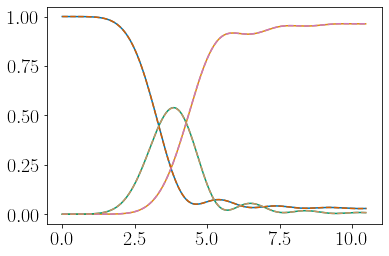

In [139]:
plt.plot(times, n_left)
plt.plot(times, n_right)
plt.plot(times, n_bond)

plt.plot(time_range, R_new, linestyle = "dashed")
plt.plot(time_range, T_new,linestyle = "dashed")
plt.plot(time_range, B_new,linestyle = "dashed")


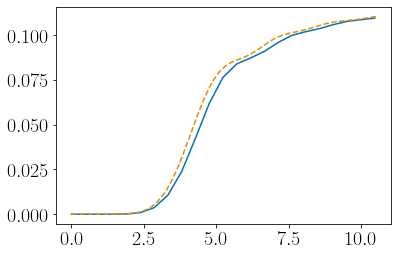

In [141]:
times_coarse = np.linspace(times[0], times[-1], len(VN_entropy))
plt.plot(times_coarse, VN_entropy)
plt.plot(time_range, St, linestyle="dashed")